In [21]:
import requests
import json
import datetime
import sqlite3
import psycopg2
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
def sql_run():
    # Connection parameters for Pagila Database
    global db_params
    db_params = {
    }

    # URL of the COVID-19 API
    global api_url
    api_url = f'https://corona.lmao.ninja/v3/covid-19/countries/'

    # Connect to the database
    global pg_connection
    pg_connection = psycopg2.connect(
        host=db_params['host'],
        database=db_params['database'],
        user=db_params['user'],
        password=db_params['password'],
        port=db_params['port'],
        options=db_params['options']
    )
    
    global pg_cursor
    pg_cursor = pg_connection.cursor()

    # Create the new table with the new column names
    pg_cursor.execute('''
        CREATE TABLE IF NOT EXISTS covid_stamp (
            Country TEXT,
            Population BIGINT,
            Cases BIGINT,
            Deaths BIGINT,
            TodayDeaths BIGINT,
            TodayRecovered BIGINT,
            Recovered BIGINT,
            InfectedPercentage FLOAT,
            DeathPercentage FLOAT,
            RecoveryPercentage FLOAT
        )
    ''')
    
    pg_cursor.execute('''
        CREATE TABLE IF NOT EXISTS api_responses (
            Timestamp TIMESTAMP,
            ResponseText TEXT,
            PRIMARY KEY (Timestamp)
        )
    ''')
    
    pg_connection.commit()

In [23]:
def round_to_2_decimal_places(number):
    rounded_number = round(number, 2)
    return rounded_number

In [24]:
def get_details(covid):
    try:
        country = covid["country"]
        population = covid["population"]
        cases = covid["cases"]
        deaths = covid["deaths"]
        recovered = covid["recovered"]
        
        # Check if population and cases are not zero before calculating percentages
        if population != 0:
            infected_percentage = round_to_2_decimal_places((cases / population) * 100)
        else:
            infected_percentage = 0.0
        
        if cases != 0:
            death_percentage = round_to_2_decimal_places((deaths / cases) * 100)
            recovery_percentage = round_to_2_decimal_places((recovered / cases) * 100)
        else:
            death_percentage = 0.0
            recovery_percentage = 0.0
        
        return infected_percentage, death_percentage, recovery_percentage
    except:
        return None


In [25]:
def run():
    # Load the latest API response timestamp from the database
    pg_cursor.execute("SELECT timestamp FROM api_responses ORDER BY timestamp DESC LIMIT 1")
    last_timestamp = pg_cursor.fetchone()
    if last_timestamp:
        last_timestamp2 = last_timestamp[0].strftime('%Y-%m-%dT%H:%M:%S')

    # Current timestamp
    current_timestamp = datetime.datetime.now().isoformat()

    # Make a request to the COVID-19 API
    response = requests.get(api_url)
    responsetext = response.text
    
    # Check if the covid_stamp table is empty
    pg_cursor.execute("SELECT COUNT(*) FROM covid_stamp")
    covid_stamp_count = pg_cursor.fetchone()[0]
    is_covid_stamp_empty = covid_stamp_count == 0

    if last_timestamp is None or last_timestamp2 < current_timestamp:
        pg_cursor.execute("SELECT responsetext FROM api_responses WHERE timestamp=%s", (last_timestamp,))
        try:
            previous_responses = pg_cursor.fetchone()[0]
        except TypeError:
            previous_responses = None

        if (previous_responses != responsetext or is_covid_stamp_empty) and previous_responses is not None:
            # Process and store new data
            data = json.loads(responsetext)
            prev_data = json.loads(previous_responses)
            
            data_changed = False
            
            prev_coun = []
            count = -1

            # Put the countries in a list alphabetically in the same order as the response text
            prev_coun = [json.dumps(prev_c) for prev_c in prev_data]

            for country in data:
                country_response_text = json.dumps(country)
                count += 1
                
                # Within the loop where each country gets iterated, compare the previous Covid details with the current one. If there's a change, only update that specific country details.
                if prev_coun[count] != country_response_text:
                    infected_percentage, death_percentage, recovery_percentage = get_details(country)
                    country_data = [country['country'], country['population'], country['cases'], country['deaths'], country['recovered'], country['todayDeaths'], country['todayRecovered'], infected_percentage, death_percentage, recovery_percentage]
                    if country_data:
                        update_query = """
                        INSERT INTO covid_stamp (Country, Population, Cases, Deaths, Recovered, TodayDeaths, TodayRecovered, InfectedPercentage, DeathPercentage, RecoveryPercentage)
                        VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
                        ON CONFLICT (Country) DO UPDATE
                        SET Population = EXCLUDED.Population, Cases = EXCLUDED.Cases, Deaths = EXCLUDED.Deaths,
                            Recovered = EXCLUDED.Recovered, TodayDeaths = EXCLUDED.TodayDeaths, TodayRecovered = EXCLUDED.TodayRecovered,
                            InfectedPercentage = EXCLUDED.InfectedPercentage, DeathPercentage = EXCLUDED.DeathPercentage,
                            RecoveryPercentage = EXCLUDED.RecoveryPercentage
                        """
                        pg_cursor.execute(update_query, country_data)
                        pg_connection.commit()
                        data_changed = True

            if data_changed:
                pg_cursor.execute("INSERT INTO api_responses (Timestamp, ResponseText) VALUES (%s, %s)", (current_timestamp, responsetext))
                pg_connection.commit()
                print("New data extracted and stored.")

            else:
                print("No new data available since the last extraction. Reason being: No change in individual Country Cases")
            
        elif previous_responses is None:
            pg_cursor.execute("INSERT INTO api_responses (Timestamp, ResponseText) VALUES (%s, %s)", (current_timestamp, responsetext))
            pg_connection.commit()
        
        else:
            print("No new data available since the last extraction. Reason being: No new Cases")

    else:
        print("No new data available since the last extraction. Reason being: Short turnaround")

# Call the run() function
# run()


In [26]:
def sql_df():

    # Fetch data from the table
    pg_cursor.execute('SELECT * FROM covid_stamp')
    rows = pg_cursor.fetchall()

    # Convert the data into a DataFrame
    column_names = [desc[0] for desc in pg_cursor.description]
    df = pd.DataFrame(rows, columns=column_names)

    # Close the cursor and connection
    pg_cursor.close()
    pg_connection.close()
    # Convert DataFrame to CSV
    csv_filename = "covid_data_updated2.csv"
    df.to_csv(csv_filename, index=False)

    return df

In [27]:
if __name__ == "__main__":
    sql_run()
    run()
    sql_df()

No new data available since the last extraction. Reason being: No new Cases


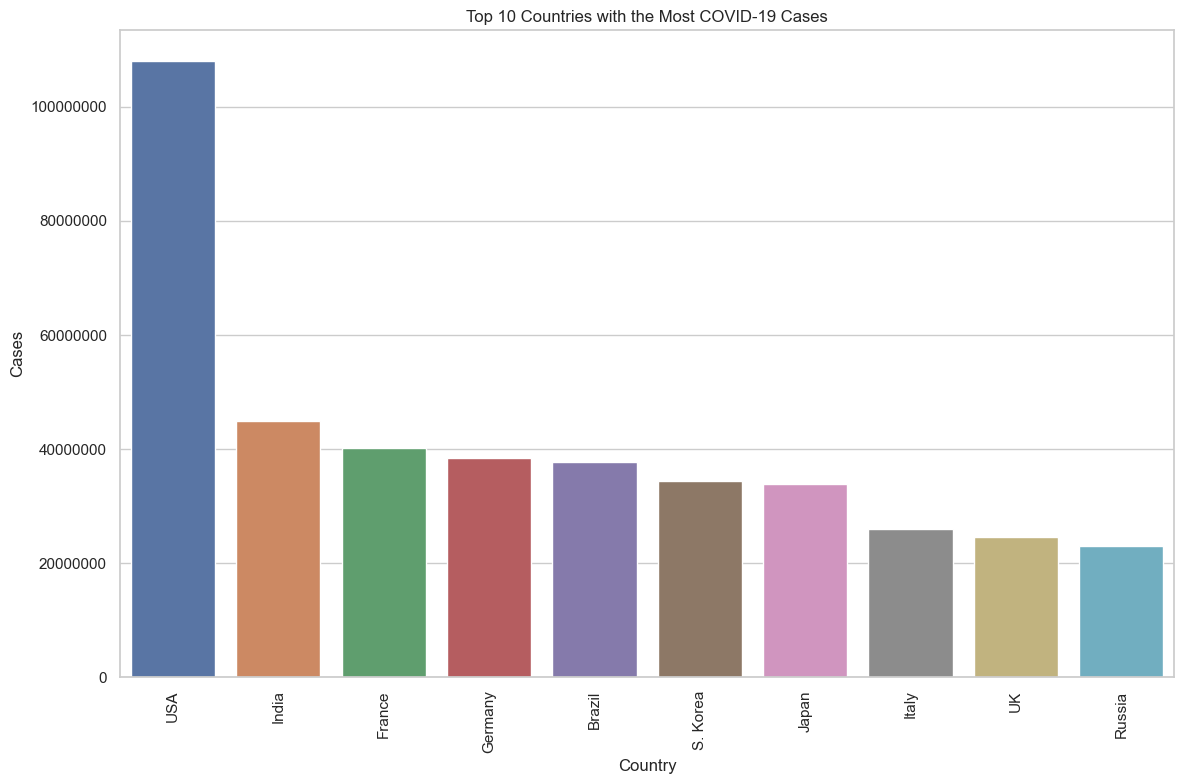

In [28]:
# Visualisations

sql_run()


# Set the style for Seaborn
sns.set(style="whitegrid")


df = sql_df()

# Sort the DataFrame by 'cases' column in descending order
df_sorted = df.sort_values(by='cases', ascending=False)

# Select the top 10 countries with the most cases
top_10_countries = df_sorted.head(10)

plt.figure(figsize=(12, 8))
sns.barplot(x='country', y='cases', data=top_10_countries)
plt.xticks(rotation=90)
plt.xlabel('Country')
plt.ylabel('Cases')
plt.title('Top 10 Countries with the Most COVID-19 Cases')
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()

# Display the plot
plt.show()

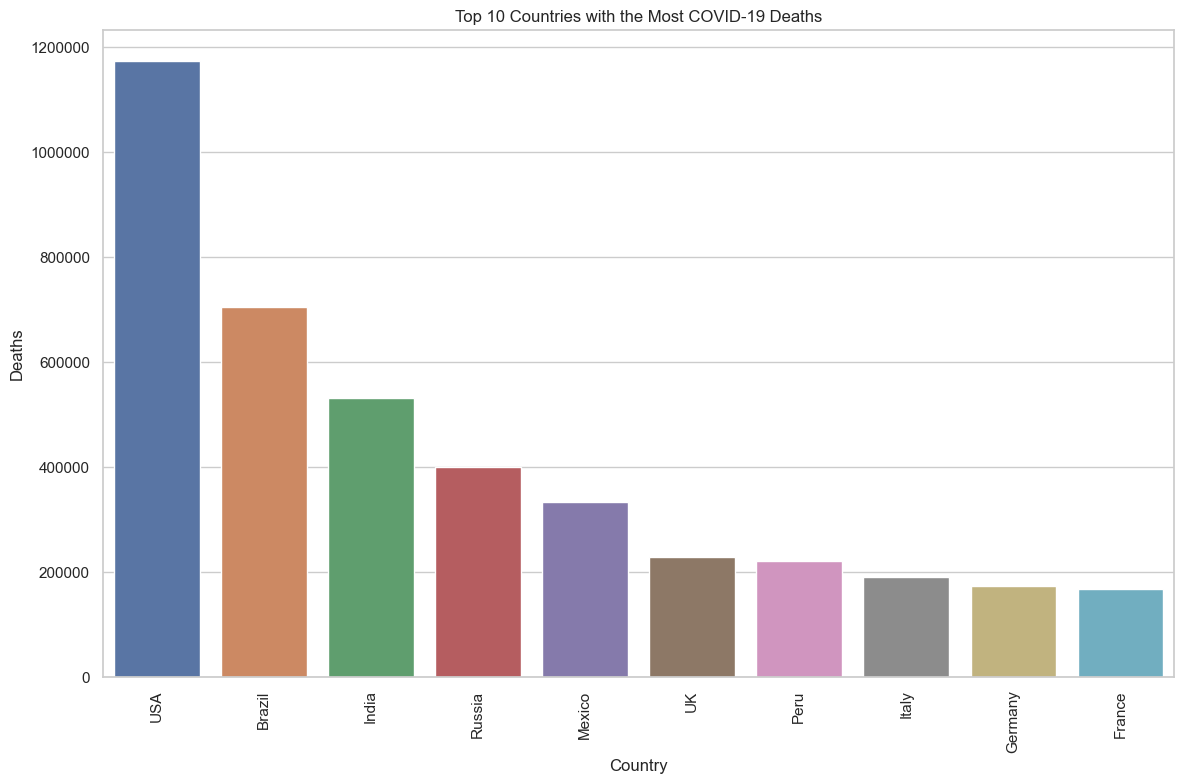

In [29]:
sql_run()

# Set the style for Seaborn
sns.set(style="whitegrid")

df = sql_df()

# Sort the DataFrame by 'deaths' column in descending order
df_sorted = df.sort_values(by='deaths', ascending=False)

# Select the top 10 countries with the most deaths
top_10_countries = df_sorted.head(10)

plt.figure(figsize=(12, 8))
sns.barplot(x='country', y='deaths', data=top_10_countries)
plt.xticks(rotation=90)

plt.xlabel('Country')
plt.ylabel('Deaths')
plt.title('Top 10 Countries with the Most COVID-19 Deaths')
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()

# Display the plot
plt.show()

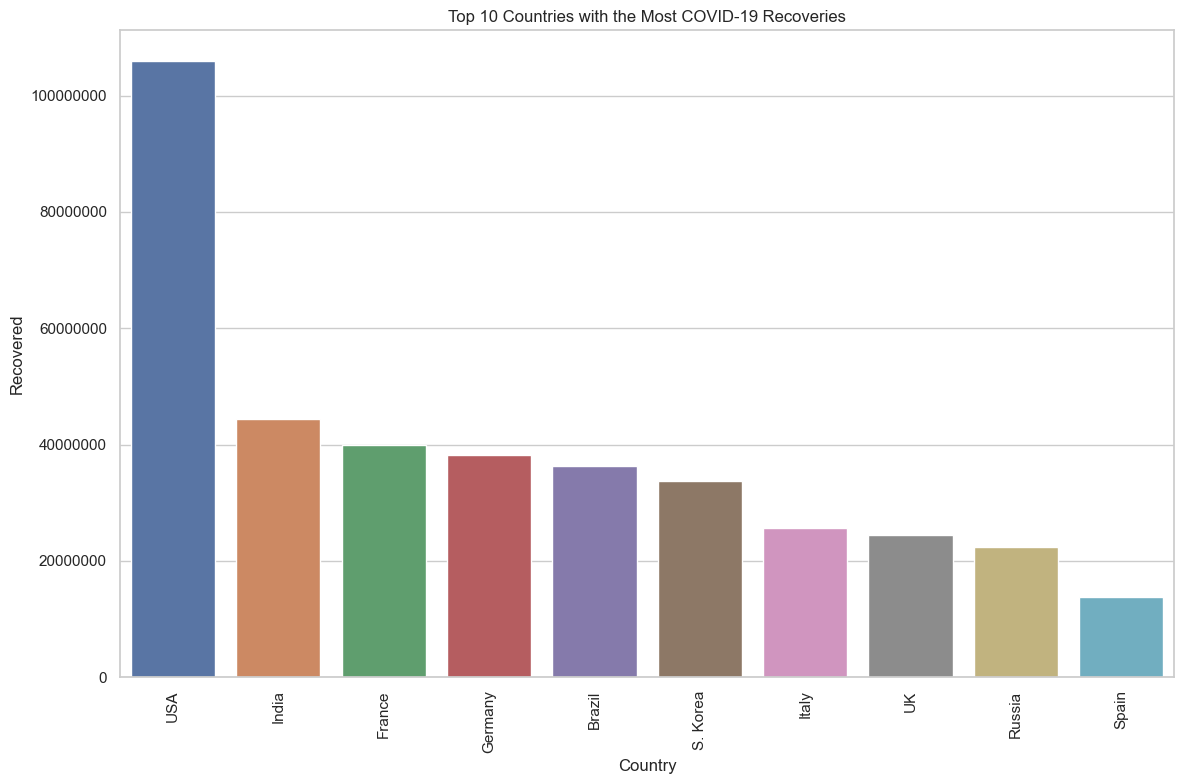

In [30]:
sql_run()

# Set the style for Seaborn
sns.set(style="whitegrid")

df = sql_df()

# Sort the DataFrame by 'recovered' column in descending order
df_sorted = df.sort_values(by='recovered', ascending=False)

# Select the top 10 countries with the most recoveries
top_10_countries = df_sorted.head(10)

plt.figure(figsize=(12, 8))
sns.barplot(x='country', y='recovered', data=top_10_countries)
plt.xticks(rotation=90)
plt.xlabel('Country')
plt.ylabel('Recovered')
plt.title('Top 10 Countries with the Most COVID-19 Recoveries')
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()

# Display the plot
plt.show()

C:\Users\hayat\AppData\Local\Temp\ipykernel_28220\4267153287.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_countries['infectedpercentage'] = top_10_countries['infectedpercentage']


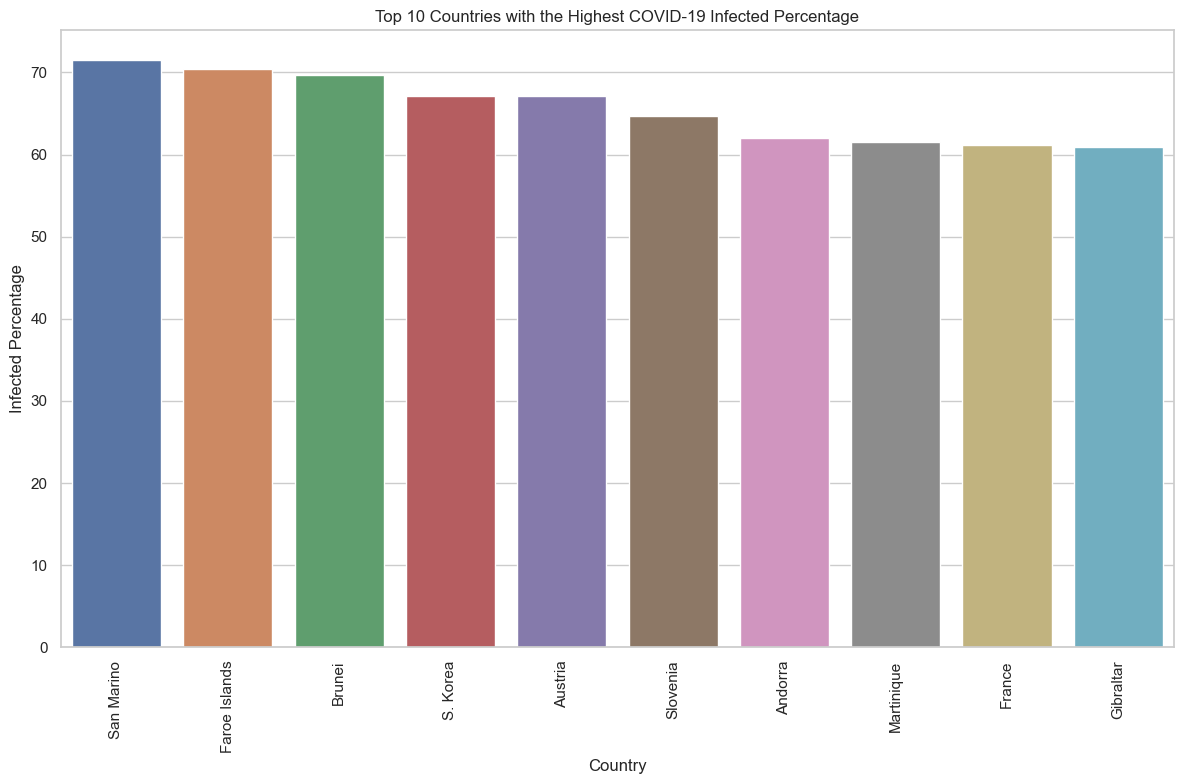

In [13]:
sql_run()
# Set the style for Seaborn
sns.set(style="whitegrid")

df = sql_df()

# Sort the DataFrame by 'infectedpercentage' column in descending order
df_sorted = df.sort_values(by='infectedpercentage', ascending=False)

# Select the top 10 countries with the highest infected percentages
top_10_countries = df_sorted.head(10)
plt.figure(figsize=(12, 8))
top_10_countries['infectedpercentage'] = top_10_countries['infectedpercentage']
sns.barplot(x='country', y='infectedpercentage', data=top_10_countries)
plt.xticks(rotation=90)
plt.xlabel('Country')
plt.ylabel('Infected Percentage')
plt.title('Top 10 Countries with the Highest COVID-19 Infected Percentage')
plt.tight_layout()

# Display the plot
plt.show()